In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from PIL import Image

Load the data

In [ ]:
X_train = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/X_train.npy')
X_val   = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/X_val.npy')
X_test  = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/X_test.npy')
y_train = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/y_train.npy')
y_val   = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/y_val.npy')
y_test  = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/y_test.npy')

In [ ]:
y_train = np.array(pd.get_dummies(y_train))
y_val = np.array(pd.get_dummies(y_val))
y_test = np.array(pd.get_dummies(y_test))

In [ ]:
print(f'X_train shape: {(X_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_test shape: {(X_test).shape}\n'
      f'y_test shape: {(y_test).shape}\n'
      f'y_val shape: {(X_val).shape}\n'
      f'X_val shape: {(y_val).shape}')

X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

X_train shape: (4569, 256, 256, 3)
y_train shape: (4569, 4)
X_test shape: (1311, 256, 256, 3)
y_test shape: (1311, 4)
y_val shape: (1143, 256, 256, 3)
X_val shape: (1143, 4)


Data augmentation

In [ ]:
train_aug = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')
train_aug.fit(X_train)

val_aug = ImageDataGenerator()
val_aug.fit(X_val)

# Custom InceptionV3

In [ ]:
base = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base.layers:
    layer.trainable = False
    print(layer.name, layer.trainable)

87910968/87910968 [==============================] - 3s 0us/step
input_1 False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed0 False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
b

In [ ]:
x = layers.GlobalMaxPooling2D()(base.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)

x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)

predict = layers.Dense(4, activation='softmax')(x)
model = Model(inputs=base.input, outputs=predict)

optim = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07, amsgrad = True)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0][0

Feature extraction

In [ ]:
batch = 64
epoch = 5

start = time.time()
history = model.fit(train_aug.flow(X_train, y_train, batch_size = batch),
                    validation_data = val_aug.flow((X_val, y_val)),
                    epochs = epoch,
                    verbose = 1,
                    steps_per_epoch = (X_train.shape[0] // batch),
                    validation_steps = (X_val.shape[0] // batch),
                    )

end = time.time()
runtime = end - start
print("Feature extraction time elapsed: ", runtime, "s")

Epoch 1/5
71/71 [==============================] - 72s 873ms/step - loss: 1.6204 - accuracy: 0.3412 - val_loss: 1.1130 - val_accuracy: 0.4871
Epoch 2/5
71/71 [==============================] - 60s 841ms/step - loss: 1.2208 - accuracy: 0.4966 - val_loss: 0.7648 - val_accuracy: 0.7316
Epoch 3/5
71/71 [==============================] - 60s 846ms/step - loss: 1.0288 - accuracy: 0.5785 - val_loss: 0.6266 - val_accuracy: 0.7592
Epoch 4/5
71/71 [==============================] - 60s 839ms/step - loss: 0.9319 - accuracy: 0.6231 - val_loss: 0.5626 - val_accuracy: 0.7886
Epoch 5/5
71/71 [==============================] - 60s 844ms/step - loss: 0.8381 - accuracy: 0.6557 - val_loss: 0.5671 - val_accuracy: 0.7868
Feature extraction time elapsed:  315.36905121803284 s


Retraining

In [ ]:
for layer in base.layers:
    layer.trainable = True

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5,
                                            min_lr=0.000001, cooldown=2)

In [ ]:
optim = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07, amsgrad = True)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0][0

In [ ]:
batch = 64
epoch = 10

start = time.time()
history = model.fit(train_aug.flow(X_train, y_train, batch_size = batch),
                    validation_data = val_aug.flow((X_val, y_val)),
                    epochs = epoch,
                    verbose = 1,
                    steps_per_epoch = (X_train.shape[0] // batch),
                    validation_steps = (X_val.shape[0] // batch),
                    callbacks = [learning_rate_reduction]
                    )

end = time.time()
runtime = end - start
print("Training time elapsed: ", runtime, "s")

Epoch 1/10
71/71 [==============================] - 98s 844ms/step - loss: 0.7934 - accuracy: 0.6855 - val_loss: 0.4688 - val_accuracy: 0.8346 - lr: 1.0000e-04
Epoch 2/10
71/71 [==============================] - 60s 838ms/step - loss: 0.4579 - accuracy: 0.8479 - val_loss: 0.3557 - val_accuracy: 0.8640 - lr: 1.0000e-04
Epoch 3/10
71/71 [==============================] - 59s 833ms/step - loss: 0.3102 - accuracy: 0.9074 - val_loss: 0.2289 - val_accuracy: 0.9154 - lr: 1.0000e-04
Epoch 4/10
71/71 [==============================] - 59s 832ms/step - loss: 0.2546 - accuracy: 0.9248 - val_loss: 0.1690 - val_accuracy: 0.9485 - lr: 1.0000e-04
Epoch 5/10
71/71 [==============================] - 59s 836ms/step - loss: 0.1922 - accuracy: 0.9443 - val_loss: 0.2192 - val_accuracy: 0.9246 - lr: 1.0000e-04
Epoch 6/10
71/71 [==============================] - 59s 832ms/step - loss: 0.1439 - accuracy: 0.9598 - val_loss: 0.1440 - val_accuracy: 0.9485 - lr: 1.0000e-04
Epoch 7/10
71/71 [======================

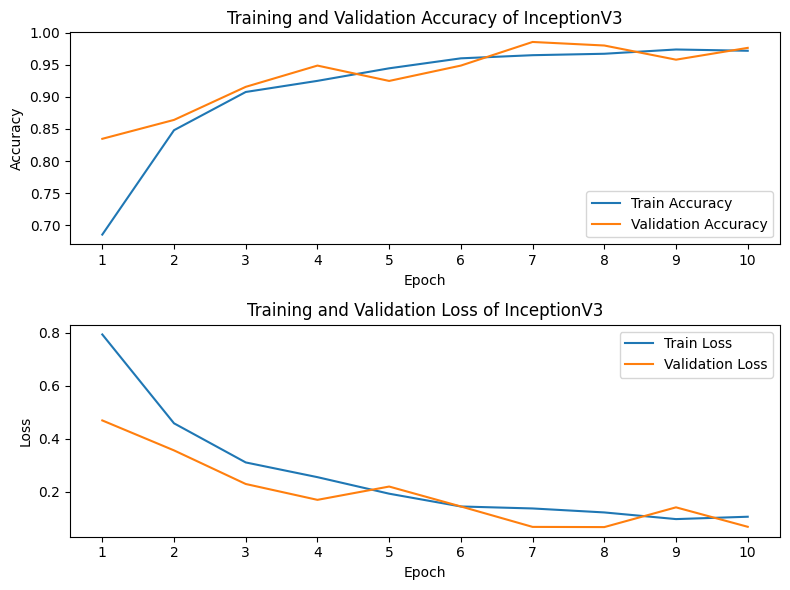

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
epochs_range = range(1,11)
# Accuracy subplot
ax1.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title(f'Training and Validation Accuracy of InceptionV3')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc = 'lower right')
ax1.set_xticks(list(epochs_range))

# Loss subplot
ax2.plot(epochs_range, history.history['loss'], label='Train Loss')
ax2.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
ax2.set_title(f'Training and Validation Loss of InceptionV3')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc = 'upper right')
ax2.set_xticks(list(epochs_range))

plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/MLMed/IV3.keras')

In [ ]:
y_true = np.argmax(y_test, axis = 1)
pred = model.predict(X_test)
y_pred = np.argmax(model.predict(X_test), axis = 1)


print(classification_report(y_true, y_pred))

41/41 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       300
           1       0.96      0.93      0.94       306
           2       0.98      1.00      0.99       405
           3       0.97      0.98      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [ ]:
dict = {0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}
classname = [dict[label] for label in np.unique(y_pred)]
print(classname)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


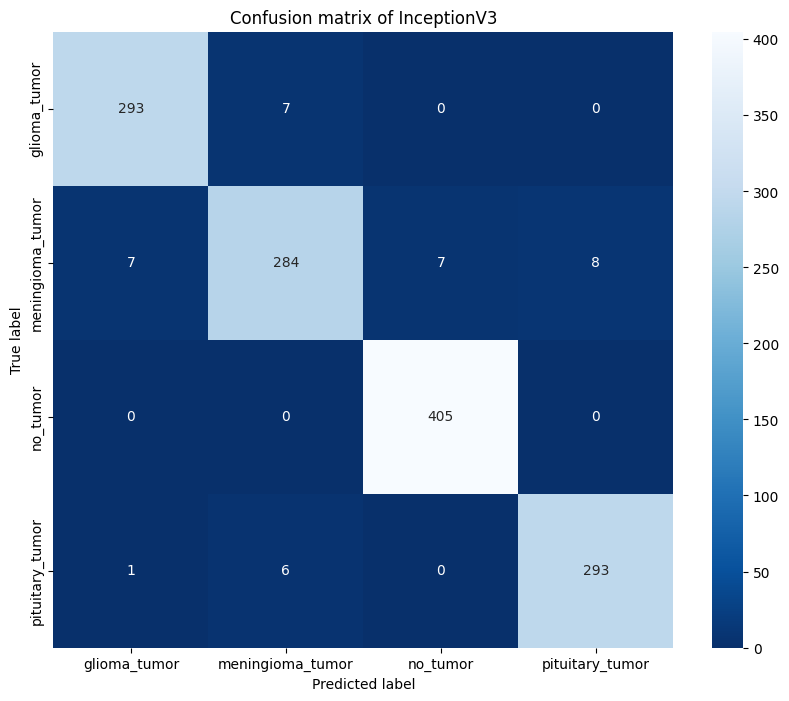

In [ ]:
plt.figure(figsize = (10, 8))
hm = sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt = 'd', cmap = 'Blues_r'
, xticklabels = classname, yticklabels = classname)
plt.title('Confusion matrix of InceptionV3')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
index = np.random.choice(len(X_test), size=100, replace=False)

fig, axs = plt.subplots(20, 5, figsize=(25, 150))

axs = axs.flatten()

for i, idx in enumerate(index):
    axs[i].imshow(X_test[idx])
    label = dict[y_pred[idx]]
    label_true = dict[y_true[idx]]
    axs[i].set_xlabel('pred: ' + label, fontsize=22, color='red')
    axs[i].set_ylabel('true: ' + label_true, fontsize=22, color='red')
    axs[i].set_xticklabels(axs[i].get_xticks(), rotation=90)
    axs[i].axis('on')

plt.tight_layout()

plt.show()

Output hidden; open in https://colab.research.google.com to view.